# ViT pretrained from huggingface for traffic sign classification

In this proof of concept, we will try to fine-tune the ViT model from huggingface for traffic sign images classification.
We will use a small dataset since the objective is the viability of this model for the specific task. More datasets are available on https://universe.roboflow.com/

In [ ]:
#pip install datasets transformers torch

In [5]:
import os
import csv
from PIL import Image
from datasets import Dataset 

# Get data + classes from csv

In [18]:
def parseData(path):
    with open(path + '_classes.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        image = []
        label = []
        classes = []
        
        for row in csv_reader:
            if line_count != 0:
                image.append(Image.open(r'' + path + row[0]))
                label.append(row[1:18].index(' 1'))
            else:
                classes = row[1:]
            line_count = line_count+1
    return image, label, classes

In [23]:

image_train, label_train, classes = parseData('data/train/')
image_test, label_test, _ = parseData('data/test/')

ds_train = Dataset.from_dict({"image": image_train, "label": label_train})
ds_test = Dataset.from_dict({"image": image_test, "label": label_test})

classes

[' ArretBus',
 ' Attention-Passage-Pieton',
 ' AttentionEnfant',
 ' Ceder-le-Passage',
 ' Demi-Tour-Interdit',
 ' Demi-Tour-Obligatoire',
 ' Double-Sens',
 ' Limite-30',
 ' Limite-50',
 ' Limite-60',
 ' Panneau',
 ' Panneau-Stop',
 ' Passage-pieton',
 ' Sens-Interdit',
 ' Sens-Unique',
 ' SensGiratoire',
 ' SensObligatoire']

# Initialize our pretrained Visual transformer feature extractor

In [28]:
from transformers import ViTFeatureExtractor
import torch

#Get feature extractor corresponding to our model from hugging_face
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

#Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

C:\Users\Rafael\anaconda3\envs\trainer\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


device(type='cuda')

# Extract features and cast to pytorch tensors

In [29]:
def pre_process(batch):
    inputs = feature_extractor(batch['image'], return_tensors='pt').to(device)
    inputs['label'] = batch['label']

    return inputs

In [30]:
# Get data as tensors and migrate to cuda device
prep_train = ds_train.with_transform(pre_process)
prep_test = ds_test.with_transform(pre_process)

In [ ]:
import numpy as np
from datasets import load_metric

def collate(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric('accuracy')
def compute_metrics(p):
    return metric.compute(
        predictions = np.argmax(p.predictions, axis=1),
        references = p.label_ids
    )

# Initialize our visual transformer classification model

In [ ]:
from transformers import ViTForImageClassification

#Get our model form huggingface
model = ViTForImageClassification.from_pretrained(model_name, num_labels = len(classes))
model.to(device)

In [ ]:
from transformers import TrainingArguments, Trainer

#Initialize trainer
training_args = TrainingArguments(
  output_dir= "./signalisation",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

# Evaluate model accuracy on our dataset before training

We get an accuracy of 0.04

In [74]:
metrics = trainer.evaluate(prep_test)
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy           =     0.0408
  eval_loss               =     2.8326
  eval_runtime            = 0:00:00.90
  eval_samples_per_second =     54.086
  eval_steps_per_second   =      7.727


# Training time...

In [75]:
#Train the model
train_results = trainer.train()
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

C:\Users\Rafael\anaconda3\envs\trainer\Lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,No log,0.311005,0.959184
200,No log,0.220361,0.959184
300,No log,0.209396,0.959184


***** train metrics *****
  epoch                    =        10.0
  total_flos               = 351515342GF
  train_loss               =        0.32
  train_runtime            =  0:02:17.76
  train_samples_per_second =      35.349
  train_steps_per_second   =        2.25


# Get accuracy after training

In [76]:
#Get accuracy after training
metrics = trainer.evaluate(prep_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)    

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9592
  eval_loss               =     0.2094
  eval_runtime            = 0:00:00.98
  eval_samples_per_second =     49.696
  eval_steps_per_second   =      7.099


The model went from 0.0408 accuracy to 0.9592 so it is a good contestant for Traffic signs classification
We observe no further improvment with our training parameters after the first Epoch
Possible improvments:
1. Use different dataset for example: https://universe.roboflow.com/search?q=signs%20traffic
2. Try different training parameters
3. Apply a mask before training on our dataset

prediciton:  Attention-Passage-Pieton


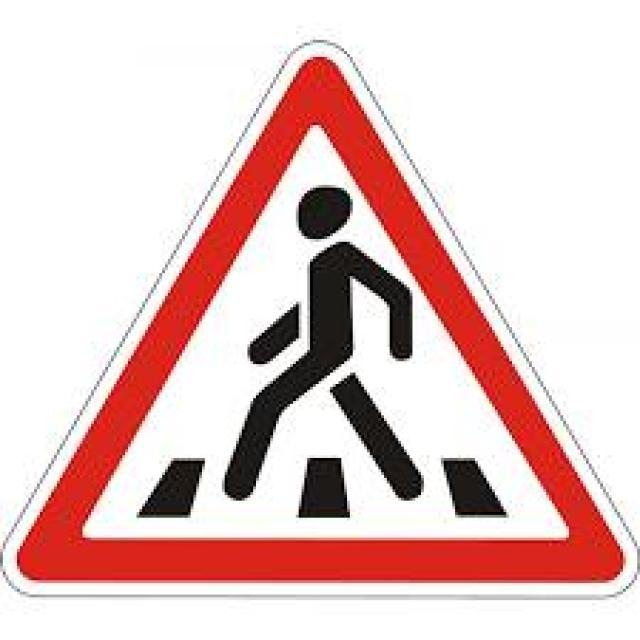

In [80]:
#Visual test
image_test = ds_train[1]['image']

inputs = image_processor(image_test, return_tensors="pt").to(device)

with torch.no_grad():
    logits = model(**inputs).logits

results = logits.detach().cpu().numpy()
bestFits = results.argmax(axis=1)
classes = np.array(classes)
print('prediciton:', classes[bestFits][0])
image_test